In [8]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Mounted at /content/drive
drive  sample_data


In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Layer, Dropout
from tensorflow.keras.experimental import LinearModel, WideDeepModel
import pandas as pd
import numpy as np

In [33]:
# simple inputs
linear_inputs = np.random.random((2, 3)) # batch_size, input
dnn_inputs = np.random.random((2, 3))
y = np.random.randint(0, 2, (2, 2))

In [34]:
linear_inputs, dnn_inputs, y

(array([[0.4199653 , 0.56434104, 0.7412466 ],
        [0.42509127, 0.5637424 , 0.82399874]]),
 array([[0.83902317, 0.1096448 , 0.59759885],
        [0.94617234, 0.58201455, 0.57216193]]),
 array([[1, 0],
        [0, 1]]))

In [35]:
# dataset：criteo dataset sample
"""
Created on July 13, 2020
dataset：criteo dataset sample
features：
- Label - Target variable that indicates if an ad was clicked (1) or not (0).
- I1-I13 - A total of 13 columns of integer features (mostly count features).
- C1-C26 - A total of 26 columns of categorical features.
The values of these features have been hashed onto 32 bits for anonymization purposes.
@author: Ziyao Geng(zggzy1996@163.com)
"""

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split


def create_criteo_dataset(file, embed_dim=8, read_part=True, sample_num=100000, test_size=0.2):
    """
    a example about creating criteo dataset
    :param file: dataset's path
    :param embed_dim: the embedding dimension of sparse features
    :param read_part: whether to read part of it
    :param sample_num: the number of instances if read_part is True
    :param test_size: ratio of test dataset
    :return: feature columns, train, test
    """
    names = ['label', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11',
             'I12', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
             'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22',
             'C23', 'C24', 'C25', 'C26']

    if read_part:
        data_df = pd.read_csv(file, sep='\t', iterator=True, header=None,
                          names=names)
        data_df = data_df.get_chunk(sample_num)

    else:
        data_df = pd.read_csv(file, sep='\t', header=None, names=names)

    sparse_features = ['C' + str(i) for i in range(1, 27)] 
    dense_features = ['I' + str(i) for i in range(1, 14)]
    features = sparse_features + dense_features # 训练使用的特征

    data_df[sparse_features] = data_df[sparse_features].fillna('-1')
    data_df[dense_features] = data_df[dense_features].fillna(0)

    # Bin continuous data into intervals. 连续型特征分箱
    est = KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='uniform')
    data_df[dense_features] = est.fit_transform(data_df[dense_features])
    # 稀疏（类别）特征编码为label
    for feat in sparse_features:
        le = LabelEncoder()
        data_df[feat] = le.fit_transform(data_df[feat])

    # ==============Feature Engineering===================

    # feature_columns = [sparseFeature(feat, int(data_df[feat].max()) + 1, embed_dim=embed_dim)
    #                     for feat in features] # 
    train, test = train_test_split(data_df, test_size=test_size)

    train_X = train[features]# .values.astype('int32')
    train_y = train['label']#.values.astype('int32')
    test_X = test[features]#.values.astype('int32')
    test_y = test['label']#.values.astype('int32')

    return sparse_features, dense_features, (train_X, train_y), (test_X, test_y)

In [36]:
file = '/content/drive/MyDrive/Colab Notebooks/wide_deep_model/data/dac_sample.txt'

In [37]:
read_part = True
sample_num = 5000000
test_size = 0.2
embed_dim = 8

In [38]:
sparse_features, dense_features, train, test = create_criteo_dataset(file=file,
                        embed_dim=embed_dim,
                        read_part=read_part,
                        sample_num=sample_num,
                        test_size=test_size)
train_X, train_y = train
test_X, test_y = test

In [39]:
train_X.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13
91744,8,59,6483,4115,23,11,3539,8,2,10746,2290,39292,1321,20,4099,13584,0,2318,337,2,19127,0,2,3041,36,3658,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82342,357,249,489,19188,23,10,7138,86,2,7338,1269,23282,637,2,1364,7353,9,836,0,0,34644,0,1,2818,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0
45329,192,115,33640,3622,23,5,4635,8,2,2505,837,39086,477,4,4606,21283,8,882,150,1,3518,0,10,10507,1,6054,0.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91668,8,21,35972,8396,23,0,6059,194,2,2505,2539,23385,1744,4,4464,1428,9,911,150,3,24334,0,1,7513,41,8774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
48653,390,250,27091,15841,51,5,2151,8,2,5390,2222,9677,233,4,2809,1924,8,2422,150,3,17711,0,3,1110,41,4125,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [40]:
linear_inputs = train_X[sparse_features].values.astype('int32')
dnn_inputs = train_X[dense_features].values.astype('int32')
y = train_y.values.astype('int32')

In [41]:
test_linear_inputs = test_X[sparse_features].values.astype('int32')
test_dnn_inputs = test_X[dense_features].values.astype('int32')
test_y = test_y.values.astype('int32')

In [42]:
linear_inputs.shape, dnn_inputs.shape, y.shape

((80000, 26), (80000, 13), (80000,))

In [43]:
# wide model
linear_model = LinearModel()

In [44]:
# deep model
dnn_model = tf.keras.Sequential()
dnn_model.add(tf.keras.layers.Embedding(input_dim=100, output_dim=8, input_length=len(dense_features)))
dnn_model.add(tf.keras.layers.Flatten()) # or concat embedding layers

In [45]:
dnn_model.add(keras.layers.Dense(units = 256))
dnn_model.add(keras.layers.Dense(units = 128))
dnn_model.add(keras.layers.Dense(units = 64))
dnn_model.add(keras.layers.Dense(units = 1, activation = None)) 

In [46]:
combined_model = WideDeepModel(linear_model, dnn_model, activation = 'sigmoid')

In [47]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam

combined_model.compile(optimizer=[Adam(learning_rate=0.0001), Adam(learning_rate=0.0001)], 
                       loss= binary_crossentropy, metrics=[AUC()])

In [48]:
epochs = 100

In [49]:
# linear_model = LinearModel()
# linear_model.compile('adagrad', 'mse')
# linear_model.fit(linear_inputs, y, epochs = epochs, batch_size=32)

In [50]:
# dnn_model.compile('rmsprop', 'mse')
# dnn_model.fit(dnn_inputs, y, epochs = epochs, batch_size=32)

In [51]:
history = combined_model.fit([linear_inputs, dnn_inputs], y, epochs = epochs, batch_size = 4096, validation_split = 0.1)

Epoch 1/100
18/18 [==============================] - 2s 51ms/step - loss: 1.4751 - auc_1: 0.5060 - val_loss: 0.8454 - val_auc_1: 0.5233
Epoch 2/100
18/18 [==============================] - 1s 38ms/step - loss: 0.7262 - auc_1: 0.5127 - val_loss: 0.6226 - val_auc_1: 0.5158
Epoch 3/100
18/18 [==============================] - 1s 37ms/step - loss: 0.5656 - auc_1: 0.5174 - val_loss: 0.5339 - val_auc_1: 0.5366
Epoch 4/100
18/18 [==============================] - 1s 38ms/step - loss: 0.5390 - auc_1: 0.5383 - val_loss: 0.5315 - val_auc_1: 0.5444
Epoch 5/100
18/18 [==============================] - 1s 37ms/step - loss: 0.5344 - auc_1: 0.5532 - val_loss: 0.5296 - val_auc_1: 0.5488
Epoch 6/100
18/18 [==============================] - 1s 38ms/step - loss: 0.5325 - auc_1: 0.5629 - val_loss: 0.5277 - val_auc_1: 0.5641
Epoch 7/100
18/18 [==============================] - 1s 39ms/step - loss: 0.5304 - auc_1: 0.5746 - val_loss: 0.5248 - val_auc_1: 0.5820
Epoch 8/100
18/18 [=============================

In [52]:
combined_model.summary()

Model: "wide_deep_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
linear_model_1 (LinearModel) multiple                  27        
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 68897     
Total params: 68,924
Trainable params: 68,924
Non-trainable params: 0
_________________________________________________________________


In [53]:
print('test mse: %f' % combined_model.evaluate([test_linear_inputs, test_dnn_inputs], test_y, batch_size=32)[1])

625/625 [==============================] - 1s 2ms/step - loss: 0.4924 - auc_1: 0.6961
test mse: 0.696082


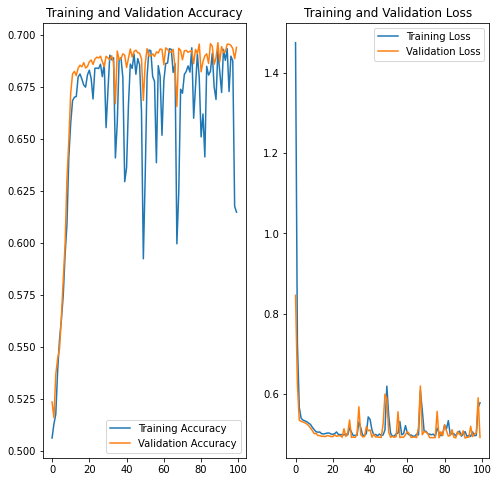

In [57]:
import matplotlib.pyplot as plt

acc = history.history['auc_1']
val_acc = history.history['val_auc_1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()